In [132]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

import torch
import torch.autograd
from torch.optim import AdamW, SGD, Adam
import torch.nn

import blah
import random
import stim
import stim_model
import cpn_model

torch.autograd.set_detect_anomaly(True)

# We will recapitulate sine waves with various starting
# frequencies. 'steps' is the trial length
steps = 200
batch_size = 256
target = torch.zeros((batch_size, steps, 2))
for bidx in range(batch_size):
    offset = bidx / float(batch_size)
    for i in range(-100, 100):
        t = 6 * (i / 100.0) + offset
        # Dim 1: the target value
        target[bidx, i + 100, 0] = torch.sin(torch.tensor(t))
        
        # Dim 2: a sort of label of the current target phase
        if i == -100:
            target[bidx, i + 100, 1] = torch.tensor(offset)
        else:
            target[bidx, i + 100, 1] = torch.tensor(0.0)
            
target = target[torch.randperm(target.shape[0]), :, :]

# A 'Thing' is the thing we are stimulating. It is basically
# a single variable diffeq-goverened system that merely dampens
# over time, except a stimulation can excite it.
class Thing(object):
    def __init__(self, init=0.0, decay=0.7):
        assert isinstance(init, float)
        self.x = init
        self.decay = decay

    def observe(self):
        return self.x

    def step(self, input):
        assert isinstance(input, float)
        self.x += input
        self.x = self.decay * self.x
        

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [173]:
# Train a BEN on a random regime; compare to some random CPNs

  
class CPNNoisey(cpn_model.CPNModel):
    def forward(self, din):
        orig = super(CPNNoisey, self).forward(din)
        
        # First third: original
        # Second third: noise added
        # Last third: noise only
        # Remember: we randomize the order of examples in the batch, so
        #   this will give us some good coverage over enough epochs
        chunk_size = din.shape[0] // 3
        out = torch.zeros(orig.shape)
        
        out[:chunk_size, :] = orig[:chunk_size, :]
        out[chunk_size:2*chunk_size, :] = orig[chunk_size:2*chunk_size, :] + torch.rand(chunk_size, orig.shape[1])
        out[-chunk_size:, :] = 6 * torch.rand(chunk_size, orig.shape[1])
        
        return out
    
class CPNNoiseyPassthrough(torch.nn.Module):
    def __init__(self, cpn):
        super(CPNNoiseyPassthrough, self).__init__()
        self.cpn = cpn
        
    def reset(self):
        self.cpn.reset()
        
    def forward(self, din):
        orig = self.cpn(din)
        
        chunk_size = din.shape[0] // 3
        out = torch.zeros(orig.shape)
        
        out[:chunk_size, :] = orig[:chunk_size, :]
        out[chunk_size:, :] = orig[chunk_size:, :] + 2 * torch.rand(orig.shape[0] - chunk_size, orig.shape[1])
        #out[chunk_size:2*chunk_size, :] = orig[chunk_size:2*chunk_size, :] + torch.rand(chunk_size, orig.shape[1])
        #out[-chunk_size:, :] = 6 * torch.rand(chunk_size, orig.shape[1])
        
        return out

def train_a_ben(cpn):
    ben = stim_model.StimModel(1 + 1 + 1, 1, num_neurons=7, activation_func=torch.nn.ReLU)
    loss = torch.nn.MSELoss()
    opt_ben = AdamW(ben.parameters(), lr=2e-3)

    for eidx in range(10000000):
        ben.reset()
        opt_ben.zero_grad()
        obs = torch.zeros(batch_size, steps)
        preds = torch.zeros(batch_size, steps)
        cpn.reset()
    
        random_targets = target[torch.randperm(target.shape[0]), :, :]
        #cpn_val = cpn_model.CPNModel(2, 1, num_neurons=7, activation_func=torch.nn.Tanh)   
        cpn_noise = CPNNoiseyPassthrough(cpn)
        things = [Thing(init=x.item()) for x in random_targets[:, 0, 0]]
        s = stim.StimulusGaussianExp(1, 1, batch_size=batch_size, pad_right_neurons=1)
        for tidx in range(steps):
            cpn_in = torch.cat((obs[:, tidx:tidx+1], random_targets[:, tidx:tidx+1, 1]), axis=1)
            new_stims = cpn_noise(cpn_in)

            s.add(new_stims)
            n = s.get_next().detach().numpy()

            new_obs = []
            for bidx in range(batch_size):
                things[bidx].step(n[bidx, 0].item())
                new_obs.append(things[bidx].observe())
            obs[:, tidx] = torch.tensor(new_obs)
        
            ben_in = torch.cat((obs[:, tidx:tidx+1], new_stims, random_targets[:, tidx:tidx+1, 1]), axis=1)
            cur_pred = ben(ben_in)
            preds[:, tidx] = cur_pred.squeeze()
        
        rl = loss(preds, obs)
        rl.backward()
        opt_ben.step()
    
        # Compare to a random CPN
        #things = [Thing(init=random_targets[bidx, 0, 0].item()) for bidx in range(batch_size)]
        #s = stim.StimulusGaussianExp(1, 1, batch_size=256, pad_right_neurons=1)
        #obs_val = torch.zeros(batch_size, steps)
        #preds_val = torch.zeros(batch_size, steps)
        #ben.reset()
        #for tidx in range(steps):
        #    cpn_in = torch.cat((obs_val[:, tidx:tidx+1], random_targets[:, tidx:tidx+1, 1]), axis=1)
        #    new_stims = cpn_val(cpn_in)

        #    s.add(new_stims)
        #    n = s.get_next().detach().numpy()

        #    new_obs = []
        #    for bidx in range(batch_size):
        #        t = things[bidx]
        #        t.step(n[bidx, 0].item())
        #        new_obs.append(t.observe())
        #    obs_val[:, tidx] = torch.tensor(new_obs)

        #    ben_in = torch.cat((obs_val[:, tidx:tidx+1], new_stims, random_targets[:, tidx:tidx+1, 1]), axis=1)
        #    cur_pred = ben(ben_in)
        #    preds_val[:, tidx] = cur_pred.squeeze()  
        #rl_val = loss(preds_val, obs_val)
        #print(eidx, rl.item(), rl_val.item())
        print("ben", eidx, rl.item())
        if rl.item() < 0.0001:
            break
            
    return ben

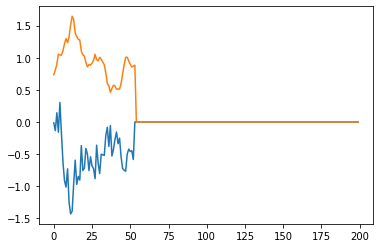

In [171]:
plt.plot(preds[200,:].detach().numpy())
plt.plot(obs[200,:].detach().numpy())
plt.show()

In [174]:
# @preston: this is the core learning algorithm, and seems to be
# able to converge if the problem is structured in a sane way.
#
# In essence: this training loop trains until the (B)EN reaches a
#  certain threshold of loss on the untrained CPN. This can take
#  awhile to converge. Once it does, the CPN will be trained. The
#  BEN is then retrained until it converges again. That way: we only
#  ever train the CPN on an 'accurate' BEN.
#
# Adding the "label" input, which is the second column in target, is
# necessary. Alternatively once could start every trial at the same
# phase - basically memorizing one exact sine wave.

# An observation of a 1 dimensional thing, 1 dimension of stimulation, 1 dimension 'label'
#  1 dimension output, predicting the next state of the thing.
#ben = stim_model.StimModel(1 + 1 + 1, 1, num_neurons=7, activation_func=torch.nn.ReLU)
#  1 dimension of stim param, output
cpn = cpn_model.CPNModel(1 + 1, 1, num_neurons=7, activation_func=torch.nn.Tanh)

loss = torch.nn.MSELoss()
opt_cpn = AdamW(cpn.parameters(), lr=4e-3)
#opt_ben = AdamW(ben.parameters(), lr=2e-3)
rli = 1
opt_str = "ben"

ben_losses = []
cpn_losses = []

while True:
    ben = get_a_ben(cpn)
    for eidx in range(500):
        cpn.reset()
        ben.reset()
        opt_cpn.zero_grad()
        opt_ben.zero_grad()
    
        if True: # rli < 1e-4 and opt_str == "ben":
            opt_str = "cpn"
            for param in cpn.parameters():
                param.requires_grad=True
            for param in ben.parameters():
                param.requires_grad=False
        else:
            opt_str = "ben"
            for param in cpn.parameters():
                param.requires_grad=False
            for param in ben.parameters():
                param.requires_grad=True

        # Probably more interesting to always start at 0, or
        thing = [Thing(init=x.item()) for x in target[:, 0, 0]]
    
        cur = target[:, 0, :].reshape(256,2)
        pred = torch.zeros((256, steps))
        # This is actually very simple in our single variable context: it outputs
        # a stimulation value which decays to 0 over time.
        # The 'padding' is a cludgy, ugly thing that you can ignore; it's for
        #  the purpose of applying to the Michaels model. I may remove it later.
        s = stim.StimulusGaussianExp(1, 1, batch_size=256, pad_right_neurons=1)

        obs = [t.observe() for t in thing]
        new_obs = torch.tensor(obs).reshape(256,1)
    
        all_obs = torch.zeros(256, steps)
        stims = []

        for tidx in range(steps):
            ind = target[:, tidx, 1].reshape(256,1)
            cpn_in = torch.cat((new_obs, ind), axis=1)
            new_stim = cpn(cpn_in)
        
            if opt_str == "cpn":
                new_stim.retain_grad()
                stims.append(new_stim)
        
            ben_in = torch.cat((new_obs, new_stim, ind), axis=1)
            cur_pred = ben(ben_in)
            pred[:, tidx] = cur_pred.squeeze()
        
            s.add(new_stim)
            n = s.get_next().detach().numpy()

            obs = []
            for bidx in range(batch_size):
                thing[bidx].step(n[bidx, 0].item())
                obs.append(thing[bidx].observe())

            new_obs = torch.tensor(obs, requires_grad=False).reshape(256,1)
            all_obs[:, tidx:tidx+1] = new_obs
        
        if opt_str == "ben":
            rl = loss(pred, all_obs)
        else:
            rl = loss(pred, target[:, :, 0])
        
        rli = rl.item()
        rl.backward()
    
        if opt_str == "ben":
            print(opt_str, eidx, rl.item())
            ben_losses.append(rli)
            opt_ben.step()
        else:
            print(opt_str, eidx, rl.item())
            cpn_losses.append(rli)
            opt_cpn.step()
            
    
plt.plot(pred[0,:].detach().numpy())
plt.plot(all_obs[0,:].detach().numpy())
plt.plot(target[0, :, 0].detach().numpy())
plt.show()

cpn 0 0.443073570728302
cpn 1 0.4543534815311432
cpn 2 0.4773451089859009
cpn 3 0.5120697617530823
cpn 4 0.5806210041046143
cpn 5 1.567172884941101
cpn 6 0.7182126045227051
cpn 7 0.8424717783927917
cpn 8 0.9244725108146667
cpn 9 1.0008026361465454
cpn 10 1.0787324905395508
cpn 11 1.1607625484466553
cpn 12 1.2484005689620972
cpn 13 1.3428964614868164
cpn 14 1.4454272985458374
cpn 15 1.55707585811615
cpn 16 1.6786843538284302
cpn 17 1.8106504678726196
cpn 18 1.952765703201294
cpn 19 2.1041855812072754
cpn 20 2.2635974884033203
cpn 21 2.4295144081115723
cpn 22 2.600649356842041
cpn 23 2.7761614322662354
cpn 24 2.9556143283843994
cpn 25 3.1389312744140625
cpn 26 3.326239585876465
cpn 27 3.6576738357543945
cpn 28 4.178687572479248
cpn 29 4.25743293762207
cpn 30 4.136875629425049
cpn 31 4.354980945587158
cpn 32 4.577688694000244
cpn 33 4.804881572723389
cpn 34 5.036454677581787
cpn 35 5.272270679473877
cpn 36 5.512237548828125
cpn 37 5.756182670593262
cpn 38 6.003947734832764
cpn 39 6.255422

KeyboardInterrupt: 

In [175]:
plt.plot([s.grad[-5].item() for s in stims])
plt.plot([0.0 for s in stims])

TypeError: 'NoneType' object is not subscriptable

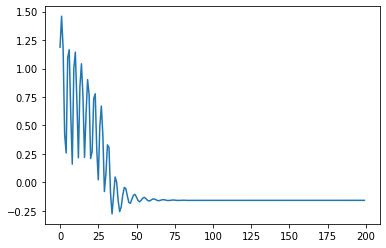

In [149]:
plt.plot([s[0].item() for s in stims])

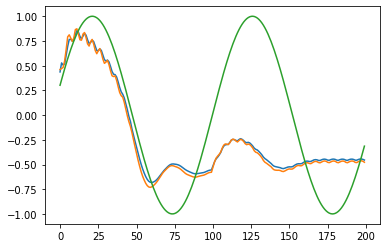

In [130]:
plt.plot(pred[1,:].detach().numpy())
plt.plot(all_obs[1,:].detach().numpy())
plt.plot(target[1,:,0].detach().numpy())
plt.show()

In [129]:

print(target[:, -100, 1])

tensor([0.6953, 0.0234, 0.6484, 0.8242, 0.1445, 0.6445, 0.0898, 0.7461, 0.4805,
        0.8594, 0.3125, 0.8984, 0.4609, 0.5859, 0.6758, 0.8750, 0.3789, 0.5664,
        0.5781, 0.0117, 0.1914, 0.2500, 0.0547, 0.4297, 0.7852, 0.7422, 0.4414,
        0.8086, 0.0664, 0.6016, 0.3438, 0.4883, 0.1719, 0.2891, 0.7578, 0.1523,
        0.9609, 0.7109, 0.6719, 0.1953, 0.0469, 0.2266, 0.2578, 0.5312, 0.0625,
        0.7227, 0.3711, 0.8516, 0.9219, 0.1289, 0.1875, 0.5547, 0.3477, 0.6406,
        0.8398, 0.3906, 0.6836, 0.0820, 0.7656, 0.0195, 0.7773, 0.3867, 0.0508,
        0.7266, 0.2305, 0.6094, 0.8047, 0.3086, 0.6523, 0.7969, 0.5938, 0.3203,
        0.0352, 0.4961, 0.3398, 0.1172, 0.1602, 0.3242, 0.1328, 0.1562, 0.9453,
        0.5000, 0.1992, 0.9336, 0.3516, 0.2109, 0.0000, 0.9805, 0.7617, 0.7383,
        0.6328, 0.1211, 0.4141, 0.4688, 0.2539, 0.1133, 0.9688, 0.9297, 0.2930,
        0.6680, 0.2070, 0.1836, 0.4375, 0.5156, 0.8906, 0.7930, 0.5078, 0.5703,
        0.1055, 0.6641, 0.3672, 0.0078, 

In [ ]:
# Example targets
    
plt.plot(target[0,:,0])
plt.plot(target[200,:,0])
    
plt.show()

tensor([ -1.7571, -10.0054,  -1.7579,   3.0444,  -1.2871,  -4.5052,  -1.2898],
       grad_fn=<AddBackward0>)


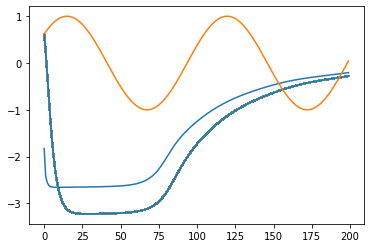

In [19]:
# Direct observation (no EN). Looks like trash. But if I 'observe' the target,
# the CPN acts generally correct. I clearly have the problem structured
# wrong. 
cpn.reset()
stims = torch.zeros(200,1)
thing = Thing(init=target[100,0,0].item())
outs = torch.zeros(200,steps)
s = stim.StimulusGaussianExp(1, 1, batch_size=1, pad_right_neurons=1)

for tidx in range(steps):
    obs = torch.tensor(thing.observe()).reshape(1,1)
    outs[tidx,:] = obs
    
    #cur = target[-2, tidx, :].reshape(1,2)
    cur = torch.cat((obs, target[100, tidx, 1].reshape(1,1)), axis=1)
    stims[tidx,:] = cpn(cur)
    #stims[tidx,:] = cpn(obs)
    
    s.add(stims[tidx,:])
    thing.step(s.get_next()[0,:1].item())
    
print(cpn.x)

plt.plot(stims.detach().numpy())
plt.plot(outs.detach().numpy())
plt.plot(target[100,:,0].detach().numpy())

In [100]:
torch.save(ben.state_dict(), 'generalizable_ben')